In [1]:
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

Load sick and healthy patients

In [2]:
with open("data/eid_sick") as f:
    eid_sick = list(map(int, f.read().split('\n')))

with open("data/eid_healthy") as f:
    eid_healthy = list(map(int, f.read().split('\n')))

len(eid_sick), len(eid_healthy)

(26314, 476056)

Load selected columns & description

In [20]:
with open("data/basic_prediction") as f:
    content = f.read().split('\n')
    columns_info = {f"{field}-0.0": desc for field, desc in [line.split('\t') for line in content]}

columns_info

{'884-0.0': 'Number of days/week of moderate physical activity 10+ minutes',
 '904-0.0': 'Number of days/week of vigorous physical activity 10+ minutes',
 '864-0.0': 'Number of days/week walked 10+ minutes',
 '1160-0.0': 'Sleep duration',
 '20160-0.0': 'Ever smoked',
 '1299-0.0': 'Salad / raw vegetable intake',
 '1349-0.0': 'Processed meat intake',
 '6144-0.0': 'Never eat eggs, dairy, wheat, sugar',
 '1438-0.0': 'Bread intake',
 '1478-0.0': 'Salt added to food',
 '1498-0.0': 'Coffee intake',
 '1528-0.0': 'Water intake',
 '1558-0.0': 'Alcohol intake frequency.'}

Read my data

In [ ]:
df = pd.read_csv('data/my_data.csv', usecols=['eid'] + list(columns_info.keys()), index_col=['eid'])
df.head()

Split into sick and healthy dataframes

In [5]:
df_sick = df.loc[eid_sick, :]
df_healthy = df.loc[eid_healthy, :]
len(df_sick), len(df_healthy)

(26314, 476056)

Take control group of healthy people, as many as the number of sick people

In [6]:
df_control = df_healthy.loc[random.sample(eid_healthy, len(eid_sick))]
len(df_control), len(df_control) == len(df_sick)

(26314, True)

Add column of diagnosis

In [7]:
df_sick['diagnosis'] = 1
df_control['diagnosis'] = 0

Merge sick and control group to one dataframe

In [8]:
df_raw = pd.concat([df_sick, df_control])
len(df_raw), len(df_raw) == 2 * len(df_sick)

(52628, True)

Check for missing values

In [9]:
df_raw.isna().sum()

864-0.0      115
884-0.0      115
904-0.0      115
1160-0.0     116
1299-0.0     116
1349-0.0     117
1438-0.0     573
1478-0.0     117
1498-0.0     117
1528-0.0     117
1558-0.0     117
6144-0.0     573
20160-0.0    391
diagnosis      0
dtype: int64

Remove rows with missing values

In [10]:
df_raw.dropna(inplace=True)
df_raw.isna().sum()

864-0.0      0
884-0.0      0
904-0.0      0
1160-0.0     0
1299-0.0     0
1349-0.0     0
1438-0.0     0
1478-0.0     0
1498-0.0     0
1528-0.0     0
1558-0.0     0
6144-0.0     0
20160-0.0    0
diagnosis    0
dtype: int64

Plot some histograms

In [105]:
def plot_histogram(data, column):
    min_ = data[column].min()
    max_ = data[column].max() + 1
    
    plt.hist(df_raw[column], np.arange(min_, max_ + 1, 1))    
    plt.title(columns_info[column])

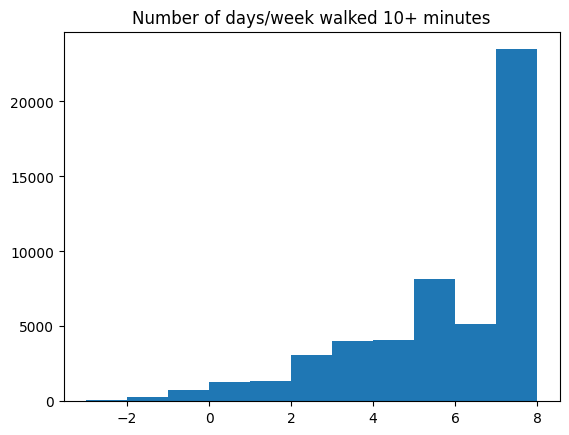

In [106]:
plot_histogram(df_raw, df_raw.columns[0])

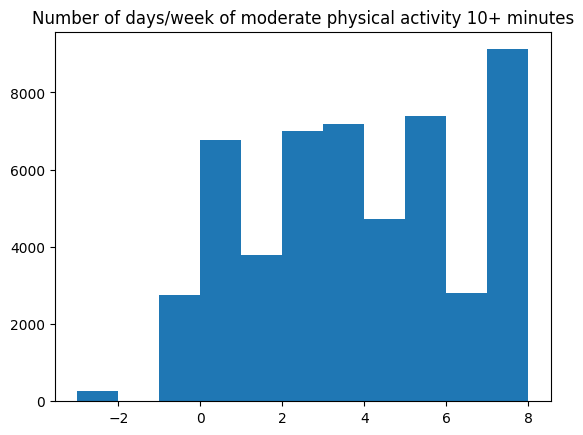

In [107]:
plot_histogram(df_raw, df_raw.columns[1])

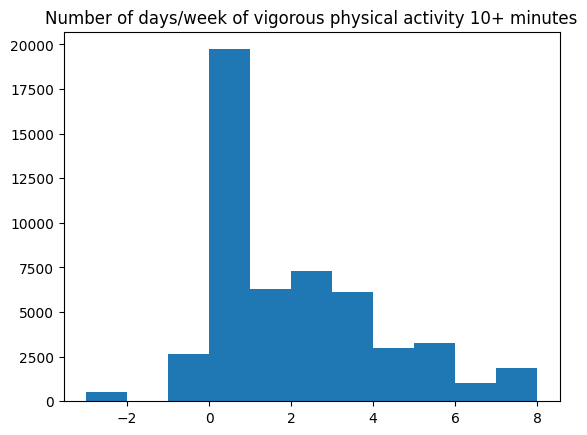

In [108]:
plot_histogram(df_raw, df_raw.columns[2])

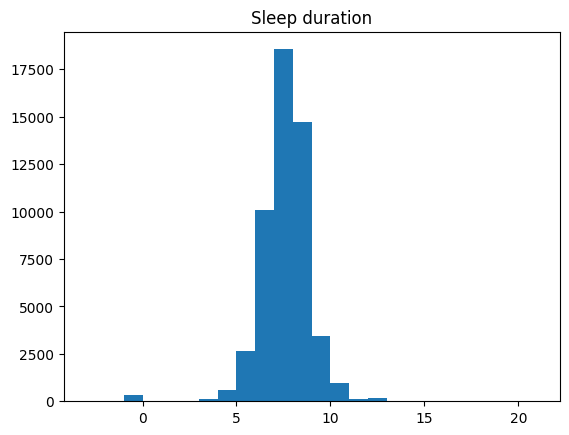

In [109]:
plot_histogram(df_raw, df_raw.columns[3])

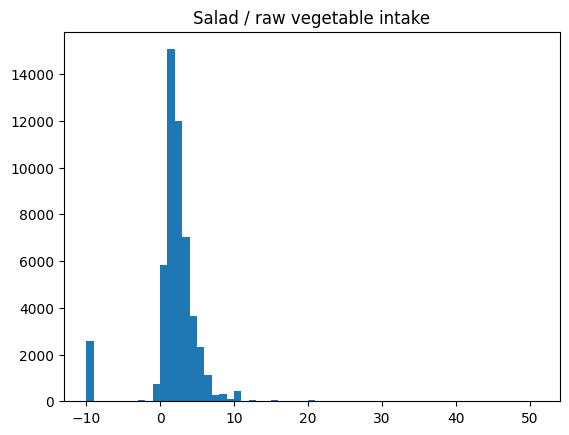

In [110]:
plot_histogram(df_raw, df_raw.columns[4])

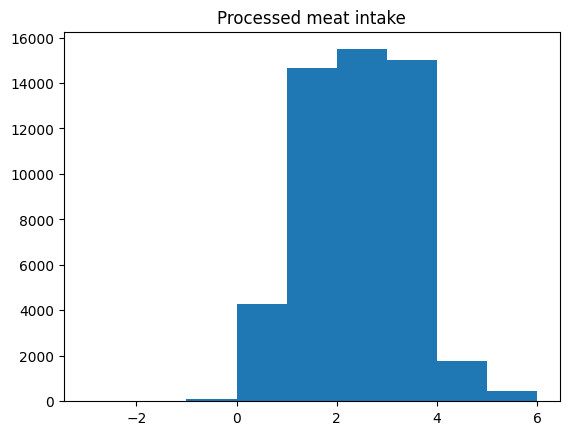

In [111]:
plot_histogram(df_raw, df_raw.columns[5])

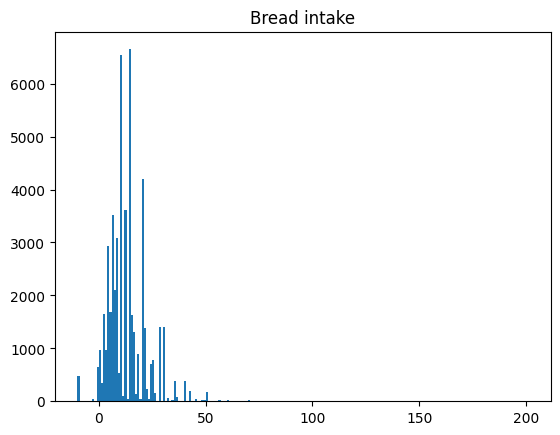

In [112]:
plot_histogram(df_raw, df_raw.columns[6])

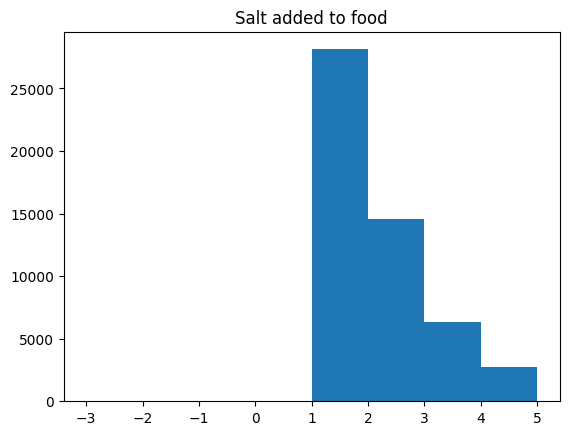

In [113]:
plot_histogram(df_raw, df_raw.columns[7])

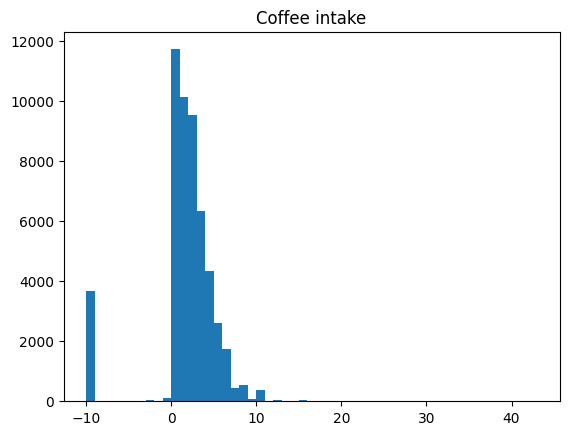

In [114]:
plot_histogram(df_raw, df_raw.columns[8])

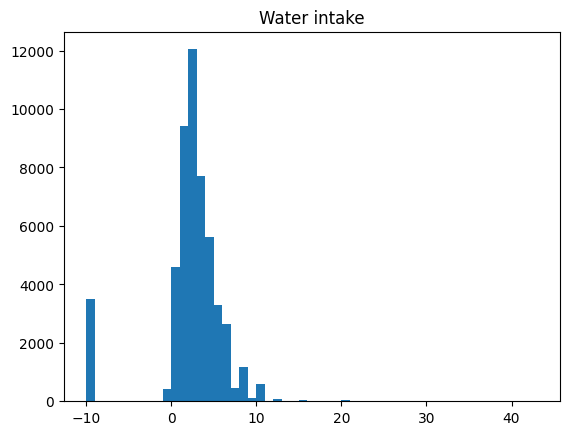

In [115]:
plot_histogram(df_raw, df_raw.columns[9])

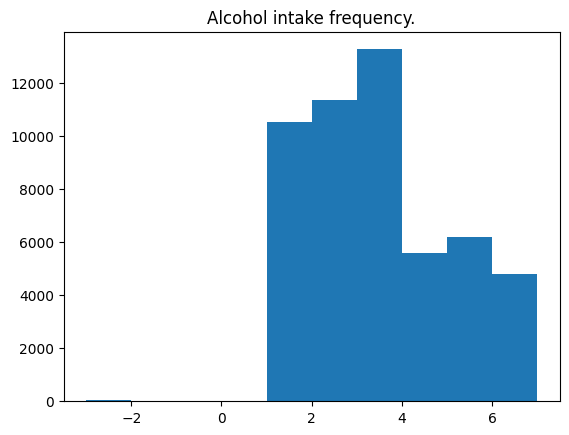

In [116]:
plot_histogram(df_raw, df_raw.columns[10])

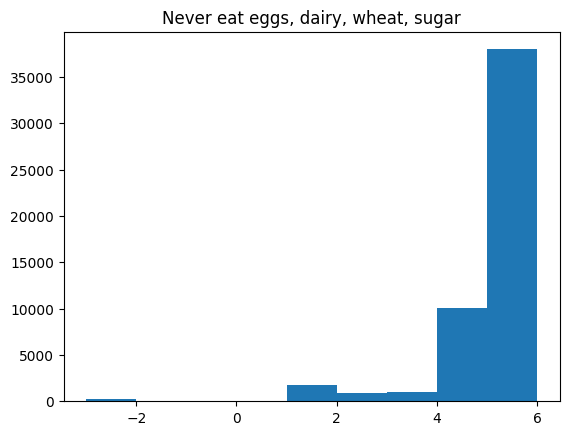

In [117]:
plot_histogram(df_raw, df_raw.columns[11])

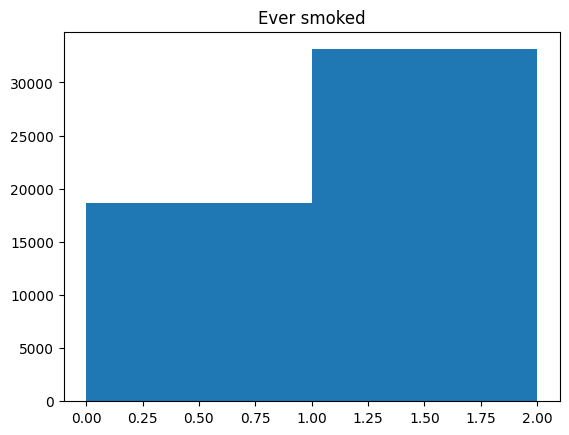

In [118]:
plot_histogram(df_raw, df_raw.columns[12])

check balance

In [11]:
print(f"all: {len(df_raw)}")
print(f"sick: {df_raw['diagnosis'].sum()}")
print(f"healthy: {len(df_raw) - df_raw['diagnosis'].sum()}")

all: 51781
sick: 25849
healthy: 25932


split to train/val/test

In [12]:
raw_data = df_raw.to_numpy()

train_data, test_data = train_test_split(raw_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_val, y_val = val_data[:, :-1], val_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

check balance once again

In [13]:
print(f"train sick: {int(y_train.sum())}/{len(y_train)}")
print(f"val sick: {int(y_val.sum())}/{len(y_val)}")
print(f"test sick: {int(y_test.sum())}/{len(y_test)}")

train sick: 16625/33139
val sick: 4074/8285
test sick: 5150/10357


define a basic experiment

In [14]:
def classify(X_train, y_train, X_val, y_val):
    
    names = [
        "KNN",
        "SVM",
        "NB",
        "LR",
        "MLP",
        "TREE",
        "RF",
        "ADA",
    ]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="rbf"),
        GaussianNB(),
        LogisticRegression(),
        MLPClassifier(max_iter=1000),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10),
        AdaBoostClassifier()
    ]

    for clf, name in zip(classifiers, names):

        clf.fit(X_train, y_train)
        score = clf.score(X_val, y_val)

        print(F"{name}: {100 * score:.2f}")

run experiment

In [15]:
classify(X_train, y_train, X_val, y_val)

KNN: 53.22
SVM: 57.44
NB: 57.08
LR: 58.01
MLP: 57.60
TREE: 57.03
RF: 58.59
ADA: 59.29


read Logistic Regression weights

In [22]:
lr = LogisticRegression().fit(X_train, y_train)

# sort columns by coefficient
col_coef = sorted(list(zip(df_raw.columns, lr.coef_[0])), key=lambda x: x[1], reverse=True)

# replace columns with description
field_coef = [(columns_info[col], coef) for col, coef in col_coef]

for f, c in field_coef:
    print(f"{f} = {c:.4f}")


Ever smoked = 0.4170
Processed meat intake = 0.1148
Alcohol intake frequency. = 0.0645
Salt added to food = 0.0484
Bread intake = 0.0198
Number of days/week of moderate physical activity 10+ minutes = 0.0024
Coffee intake = -0.0008
Sleep duration = -0.0016
Water intake = -0.0076
Salad / raw vegetable intake = -0.0111
Number of days/week of vigorous physical activity 10+ minutes = -0.0122
Number of days/week walked 10+ minutes = -0.0140
Never eat eggs, dairy, wheat, sugar = -0.1529
